In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    average_precision_score, precision_recall_curve,
    confusion_matrix, classification_report,f1_score,precision_score,recall_score
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC



In [2]:
data = pd.read_csv("./data/fraud_detection_data.csv")

print("\nCouple of rows:")
print(data.head())

print("\nHow many merchants and customers:")
print(data['nameDest'].str[0].value_counts())

print("\nShape of the data:\n")
print(data.shape)

print("\nDescription of the data:\n")
print(data.describe())

print("\nInfo about the data:\n")
print(data.info())

print("\n null values in the data:\n")
data.isnull().sum()

#making copy od data (work and modify on data_clean)
data_clean = data.copy()



C:\Users\dell\AppData\Local\Temp\ipykernel_16896\735665243.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./data/fraud_detection_data.csv")



Couple of rows:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud isFlaggedFraud  
0  M1979787155             0.0             0.0        0              0  
1  M2044282225             0.0             0.0        0              0  
2   C553264065             0.0             0.0        1             0x  
3    C38997010         21182.0             0.0        1              0  
4  M1230701703             0.0             0.0        0              0  

How many merchants and customers:
nameDest
C    4211125
M    2151495
Name: count, dtype: int6

In [3]:
data["type"].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [4]:
#checking for any negative values .lt(0) cz it is impossible in accounts
balance_cols = [
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest"
]

data[balance_cols].lt(0).any()

oldbalanceOrg     False
newbalanceOrig    False
oldbalanceDest    False
newbalanceDest    False
dtype: bool

In [5]:
print(f"how many fraud incidents: \n {data['isFraud'].value_counts()}")
data.groupby("type")["isFraud"].mean().sort_values(ascending=False)


how many fraud incidents: 
 isFraud
0    6354407
1       8213
Name: count, dtype: int64


type
TRANSFER    0.007688
CASH_OUT    0.001840
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64

In [9]:
#checking and dropping the all zero rows or accounts 
zero_rows = data[
    (data["amount"] == 0) &
    (data["oldbalanceOrg"] == 0) &
    (data["newbalanceOrig"] == 0) &
    (data["oldbalanceDest"] == 0) &
    (data["newbalanceDest"] == 0)
]

print("Number of zero rows:", len(zero_rows))
zero_rows.head(6)

#dropping them 
data = data.drop(zero_rows.index)


Number of zero rows: 0


In [21]:
# making a feature out of these mismatching rows
tol = 1e-6
data_clean["orig_mismatch_flag"] = (~np.isclose(data["newbalanceOrig"], data["oldbalanceOrg"] - data["amount"], atol=tol)).astype(int)
data_clean["dest_mismatch_flag"] = (~np.isclose(data["newbalanceDest"], data["oldbalanceDest"] + data["amount"], atol=tol)).astype(int)


ValueError: Length of values (6362614) does not match length of index (6362620)

In [ ]:
#checking for 0 values count beside the dropped columns 
numeric = data.select_dtypes(include="number").columns.drop("isFraud").drop("step")
(data[numeric] == 0).sum().sort_values(ascending=False).reset_index()



,index,0
0,newbalanceOrig,3609560
1,oldbalanceDest,2704382
2,dest_mismatch_flag,2538715
3,newbalanceDest,2439427
4,oldbalanceOrg,2102443
5,orig_mismatch_flag,1360768
6,amount,10


In [12]:
#checking the suspicious accounts and calculating the fraud mean only in ("TRANSFER","CASH_OUT")
suspect1 = data[
    (data["oldbalanceOrg"] == 0) &
    (data["amount"] > 0) &
    (data["type"].isin(["TRANSFER","CASH_OUT"]))
]

suspect2 = data[
    (data["newbalanceDest"] == 0) &
    (data["amount"] > 0) &
    (data["type"].isin(["TRANSFER","CASH_OUT"]))
]
suspect3 = data[
    (data["oldbalanceDest"] ==0) &
    (data["amount"] > 0)&
    (data["type"].isin(["TRANSFER","CASH_OUT"]))

]

print("Fraud rate suspect1:", suspect1["isFraud"].mean())
print("Fraud rate suspect2:", suspect2["isFraud"].mean())
print("Fraud rate suspect3:", suspect3["isFraud"].mean())



Fraud rate suspect1: 1.9104882749513588e-05
Fraud rate suspect2: 0.24618815163020552
Fraud rate suspect3: 0.013729277652486167


C:\Users\dell\AppData\Local\Temp\ipykernel_16896\1683141027.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_bin = data.groupby("amount_bin")["isFraud"].mean()


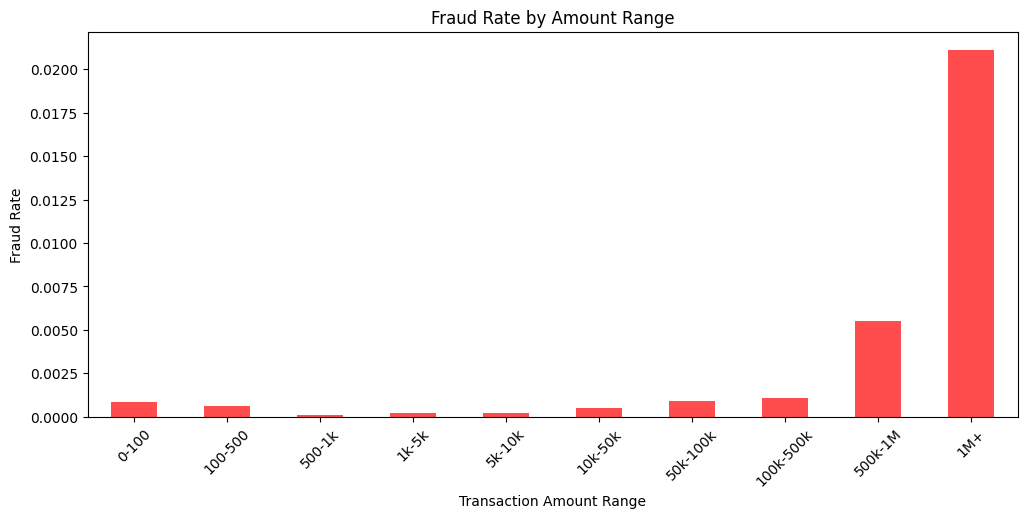

In [13]:
#need to visualize the fraud rate with amount so divided them to bins 
bins = [0, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1e6, 1e7]
labels = ["0-100","100-500","500-1k","1k-5k","5k-10k","10k-50k","50k-100k","100k-500k","500k-1M","1M+"]

data["amount_bin"] = pd.cut(data["amount"], bins=bins, labels=labels, include_lowest=True)

fraud_rate_by_bin = data.groupby("amount_bin")["isFraud"].mean()

plt.figure(figsize=(12,5))
fraud_rate_by_bin.plot(kind="bar", color="red", alpha=0.7)
plt.title("Fraud Rate by Amount Range")
plt.xlabel("Transaction Amount Range")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=45)
plt.show()


In [ ]:

data_clean["orig_mismatch_flag"] = (~np.isclose(data_clean["newbalanceOrig"], data_clean["oldbalanceOrg"] - data_clean["amount"], atol=tol)).astype(int)
data_clean["dest_mismatch_flag"] = (~np.isclose(data_clean["newbalanceDest"], data_clean["oldbalanceDest"] + data_clean["amount"], atol=tol)).astype(int)

data_clean["suspicious_dest_balance"] = ((data_clean["newbalanceDest"]==0) & 
                                         (data_clean["amount"]>0) & 
                                         (data_clean["type"].isin(["TRANSFER","CASH_OUT"]))).astype(int)

data_clean["name_org_type"] = data_clean["nameOrig"].str[0]
data_clean["name_dest_type"] = data_clean["nameDest"].str[0]

# Destination features
data_clean = data_clean.sort_values("step")
data_clean["dest_count_so_far"] = data_clean.groupby("nameDest").cumcount() + 1
data_clean["is_unique_dest_time_safe"] = (data_clean["dest_count_so_far"]==1).astype(int)
data_clean["is_first_time_dest"] = data_clean["is_unique_dest_time_safe"]
data_clean["dest_count"] = data_clean["nameDest"].map(data_clean["nameDest"].value_counts())
data_clean["dest_seen_before"] = (data_clean.groupby("nameDest").cumcount() > 0).astype(int)

# Sender features
data_clean["origin_txn_count"] = data_clean.groupby("nameOrig").cumcount()
data_clean["high_amount_flag"] = (data_clean["amount"]>1_000_000).astype(int)
data_clean["sus_sender"] = ((data_clean["high_amount_flag"]==1) & (data_clean["origin_txn_count"]<3)).astype(int)
data_clean["sus_sender_dest"] = ((data_clean["is_unique_dest_time_safe"]==1) & (data_clean["sus_sender"]==1)).astype(int)

# Frequency features
data_clean["freq_sender_step"] = data_clean.groupby("nameOrig").cumcount() + 1
data_clean["freq_sus_sender"] = ((data_clean["freq_sender_step"]>=1) & (data_clean["sus_sender"]==1)).astype(int)
data_clean["freq_sus_num_of_sendings"] = data_clean["freq_sender_step"] * data_clean["sus_sender"]

# Ratios and risk signal
data_clean["amount_to_orig_balance_ratio"] = data_clean["amount"] / (data_clean["oldbalanceOrg"] + 1)
data_clean["amount_to_dest_balance_ratio"] = data_clean["amount"] / (data_clean["oldbalanceDest"] + 1)
data_clean["txn_risk_signal"] = data_clean["amount_to_dest_balance_ratio"] * (data_clean["sus_sender_dest"] + 1) * (data_clean["dest_seen_before"] + 1)

# Fix 0x in isFlaggedFraud
data_clean["isFlaggedFraud"] = data_clean["isFlaggedFraud"].replace("0x", 0).astype(int)


In [15]:
numeric_col=data_clean.select_dtypes(include="number").columns.drop("isFraud")
corr_with_target = data_clean[numeric_col].corrwith(data_clean["isFraud"]).abs()
corr_with_target = corr_with_target.sort_values(ascending=False)
corr_with_target

suspicious_dest_balance         0.348773
amount_to_dest_balance_ratio    0.180205
txn_risk_signal                 0.176340
sus_sender_dest                 0.146344
freq_sus_num_of_sendings        0.078352
sus_sender                      0.078326
freq_sus_sender                 0.078326
high_amount_flag                0.078326
amount                          0.076688
orig_mismatch_flag              0.068446
isFlaggedFraud                  0.044109
step                            0.031578
is_unique_dest_time_safe        0.014686
dest_seen_before                0.014686
is_first_time_dest              0.014686
dest_count_so_far               0.010972
oldbalanceOrg                   0.010154
dest_count                      0.008982
newbalanceOrig                  0.008148
dest_mismatch_flag              0.006257
oldbalanceDest                  0.005885
amount_to_orig_balance_ratio    0.004915
freq_sender_step                0.000681
origin_txn_count                0.000681
newbalanceDest  

In [16]:
numeric_features = data_clean.select_dtypes(include="number").columns.drop("isFraud")
categorical_features = data_clean.select_dtypes(include="object").columns.drop(["nameOrig","nameDest"])

split_step = int(data_clean["step"].max() * 0.8)
train_data = data_clean[data_clean.step <= split_step]
test_data = data_clean[data_clean.step > split_step]

train_X = train_data[numeric_features.tolist() + categorical_features.tolist()]
train_y = train_data["isFraud"]
test_X = test_data[numeric_features.tolist() + categorical_features.tolist()]
test_y = test_data["isFraud"]

# Preprocessors
preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

preprocessor_trees = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

In [17]:
#Logistic regression
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=1000))
])

# Random forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor_trees), 
    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=42))
])

# XGBoost
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor_trees), 
    ('clf', XGBClassifier(
        n_estimators=200,
        scale_pos_weight=(train_y.value_counts()[0]/train_y.value_counts()[1]),
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
        random_state=42
    ))
])

# CatBoost
cat_pipeline = Pipeline([
    ('preprocessor', preprocessor_trees),  
    ('clf', CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        loss_function='Logloss',           
        eval_metric='PRAUC',               
        verbose=0,
        random_seed=42,
        class_weights=[1, train_y.value_counts()[0]/train_y.value_counts()[1]]
    ))
])

In [18]:
def evaluate_model(pipeline, train_X, train_y, test_X, test_y, best_thr=None):
    """
    Fit model, find best threshold by F1, plot PR curve, and show metrics.
    """
    pipeline.fit(train_X, train_y)
    pred_probs = pipeline.predict_proba(test_X)[:,1]

    if best_thr is None:
        precision, recall, thresholds = precision_recall_curve(test_y, pred_probs)
        f1_scores = 2*precision*recall/(precision+recall+1e-10)
        best_f1_idx = np.argmax(f1_scores)
        best_thr = thresholds[best_f1_idx]
        print(f"Best threshold by F1: {best_thr:.3f}, F1={f1_scores[best_f1_idx]:.3f}")

    pred_labels = (pred_probs >= best_thr).astype(int)

    cm = confusion_matrix(test_y, pred_labels)
    print(f"\nConfusion Matrix:\n{cm}")

    report = classification_report(test_y, pred_labels)
    print(f"\nClassification Report:\n{report}")

    pr_auc = average_precision_score(test_y, pred_probs)
    print(f"\nAverage Precision Score (PR-AUC): {pr_auc:.4f}")

    
    return pred_probs, pred_labels, best_thr



===== Evaluating Logistic Regression =====
Best threshold by F1: 0.984, F1=0.806

Confusion Matrix:
[[121922      4]
 [   534   1120]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121926
           1       1.00      0.68      0.81      1654

    accuracy                           1.00    123580
   macro avg       1.00      0.84      0.90    123580
weighted avg       1.00      1.00      1.00    123580


Average Precision Score (PR-AUC): 0.8192

===== Evaluating Random Forest =====
Best threshold by F1: 0.857, F1=0.121

Confusion Matrix:
[[110724  11202]
 [   827    827]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95    121926
           1       0.07      0.50      0.12      1654

    accuracy                           0.90    123580
   macro avg       0.53      0.70      0.53    123580
weighted avg       0.98      0.90      0.94  

c:\Users\dell\Desktop\Fraud_Detection\fraud_detection_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:47:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best threshold by F1: 0.857, F1=0.121

Confusion Matrix:
[[110724  11202]
 [   827    827]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95    121926
           1       0.07      0.50      0.12      1654

    accuracy                           0.90    123580
   macro avg       0.53      0.70      0.53    123580
weighted avg       0.98      0.90      0.94    123580


Average Precision Score (PR-AUC): 0.0505

===== Evaluating CatBoost =====
Best threshold by F1: 0.856, F1=0.121

Confusion Matrix:
[[110724  11202]
 [   827    827]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95    121926
           1       0.07      0.50      0.12      1654

    accuracy                           0.90    123580
   macro avg       0.53      0.70      0.53    123580
weighted avg       0.98      0.90      0.94    123580


Average Precision Score (PR-AUC): 0.05

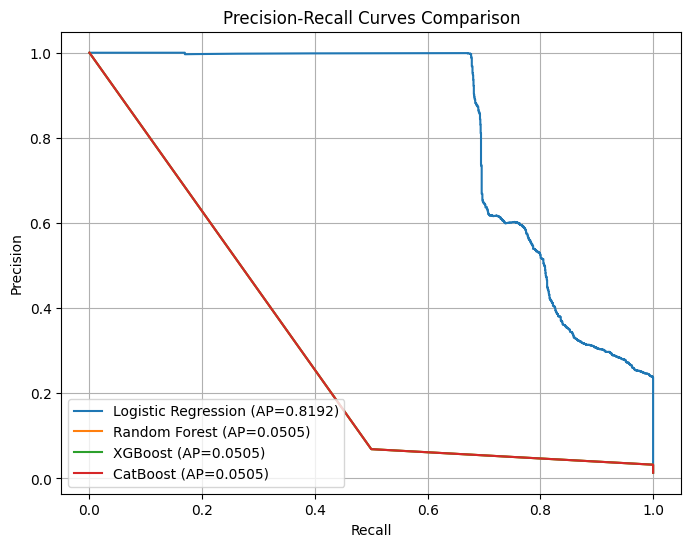


===== Summary of All Models =====
                 Model  Best Threshold        F1  Precision    Recall  \
0  Logistic Regression        0.984370  0.806335   0.996441  0.677146   
1        Random Forest        0.857355  0.120880   0.068751  0.500000   
2              XGBoost        0.857204  0.120880   0.068751  0.500000   
3             CatBoost        0.856250  0.120880   0.068751  0.500000   

     PR-AUC  
0  0.819172  
1  0.050501  
2  0.050501  
3  0.050501  


In [19]:

models = {
    "Logistic Regression": lr_pipeline,
    "Random Forest": rf_pipeline,
    "XGBoost": xgb_pipeline,
    "CatBoost": cat_pipeline
}
results = []

plt.figure(figsize=(8,6))
for name, pipeline in models.items():
    print(f"\n===== Evaluating {name} =====")
    pred_probs, pred_labels, best_thr = evaluate_model(pipeline, train_X, train_y, test_X, test_y)
    
    pr_auc = average_precision_score(test_y, pred_probs)
    f1 = f1_score(test_y, pred_labels)
    precision = precision_score(test_y, pred_labels)
    recall = recall_score(test_y, pred_labels)

    results.append({
        "Model": name,
        "Best Threshold": best_thr,
        "F1": f1,
        "Precision": precision,
        "Recall": recall,
        "PR-AUC": pr_auc
    })
    
    # Plot PR curve
    precision_vals, recall_vals, _ = precision_recall_curve(test_y, pred_probs)
    plt.plot(recall_vals, precision_vals, label=f"{name} (AP={pr_auc:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves Comparison")
plt.legend()
plt.grid(True)
plt.show()

# Summary table
results_df = pd.DataFrame(results).sort_values(by="PR-AUC", ascending=False)
print("\n===== Summary of All Models =====")
print(results_df)


In [20]:
cat_indices = [train_X.columns.get_loc(col) for col in categorical_features]

smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42)
train_X_res, train_y_res = smote_nc.fit_resample(train_X, train_y)


MemoryError: Unable to allocate 7.65 GiB for an array with shape (6225922, 5, 33) and data type float64

In [ ]:
# Evaluate models after SMOTE
smote_results = []

plt.figure(figsize=(8,6))
for name, pipeline in models.items():

    print(f"\n===== Evaluating {name} (with SMOTE) =====")
    pred_probs, pred_labels, best_thr = evaluate_model(pipeline, train_X_res, train_y_res, test_X, test_y)
    
    pr_auc = average_precision_score(test_y, pred_probs)
    f1 = f1_score(test_y, pred_labels)
    precision = precision_score(test_y, pred_labels)
    recall = recall_score(test_y, pred_labels)

    smote_results.append({
        "Model": name,
        "Best Threshold": best_thr,
        "F1": f1,
        "Precision": precision,
        "Recall": recall,
        "PR-AUC": pr_auc
    })

    # Plot PR curve
    precision_vals, recall_vals, _ = precision_recall_curve(test_y, pred_probs)
    plt.plot(recall_vals, precision_vals, label=f"{name} (AP={pr_auc:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curves Comparison (Tree Models with SMOTE)")
plt.legend()
plt.grid(True)
plt.show()

smote_results_df = pd.DataFrame(smote_results).sort_values("PR-AUC", ascending=False)
print("\n===== Summary of Tree Models with SMOTE =====")
print(smote_results_df)
